# 第8章 DQN改进算法

In [7]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
import cv2
import imageio

## 构造智能体agent的大脑，也就是输入状态，返回该状态下，每个动作的动作价值
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim，
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  ## full connect层1
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim) ## full connect层2

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [20]:
##  构造智能体的
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim  ##  动作的dim
        ## 实例化智能体的大脑
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        # if np.random.random() < self.epsilon * np.exp(-self.count/100):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim) ## 随机选择一个动作
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device) ## 状态
            action = self.q_net(state).argmax().item()  ## 智能体的大脑，根据状态拿到动作价值，q_net返回值是每个动作的动作价值，然后拿到动作的
        return action

    ## 拿到一个状态对应的所有动作的动作价值，并返回动作价值的最大值
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    ## 使用历史数据来训练智能体的大脑，两个大脑的，一个实时update做label，另一个延迟update做predict
    '''
    损失函数需要label和predict，但是强化学习是没有label的，所以需要人工构造label才行，DQN使用的构造方式是使用update步长不相同的两个Qnet，
    update数量较多的Qnet来做label，数量较少的Qnet来做predict。所以label就是使用的newest update的Qnet。相当是两个人，一个学的时间长些，
    一个学的时间短些，所以这个学习时间更长的人，可以当老师了，学习时间短的人，就只能当学生了。老师可以教导学生的。所以两个大脑模型Qnet，
    一个做老师，一个是学生，也就是一个label另一个则是predict。这样就构造出了相应的label。
    target_q_net使用下一个状态，然后Q-learning来predict当前(状态，动作)的动作价值，predict
    q_net使用当前状态和动作，直接算出当前(状态，动作)的动作价值，label
    '''
    def update(self, transition_dict):
        ## 初始化 状态、动作、奖励、下一个状态、是否结束的
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        ## target, 因该网络实时update，所以可以看作是真实值，也就是监督学习内的label，而目标网络延迟很多，目标网络的输出可以看作predict
        ## “真实”label，q_net输入当前的状态，返回值是当前状态下每个动作的动作价值，所以gather以后拿到的是：当前(状态和动作)对应的动作价值
        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)    ## 统一动作网络，由q_net网络来给出下个状态的动作，标准是最大值
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)    ## target_q_net网络给出动作价值，并通过动作选择动作价值
        else: # DQN的情况
            ## target_q_net网络给出动作价值，并直接挑选某个状态动作内的最大值，和q_net的动作可能不相同
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        ## Q-learning algorithm，算出的是当前(状态和动作)的动作价值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        ## q_net的truth label 和 target_q_net的predict，算损失用来反向传播
        ## 也就是两个网络算出来的（状态和动作）对应的动作价值，用MSE来算损失函数的呢
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()   ##  反向传播求出梯度
        self.optimizer.step() ##  使用累加的梯度来update参数

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [21]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /(action_dim - 1)) * (action_upbound - action_lowbound)

In [22]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    allimage = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0   ## 累积的奖励
                state = env.reset()  ## 环境随机重置的
                if len(state)!=3:
                    state = state[0]
                done = False
                # https://huggingface.co/learn/deep-rl-course/unit4/hands-on#create-a-virtual-display
                while not done:
                    if (i_episode + 1) % 10 == 0 and i in [9]:
                        img = env.render()
                        allimage.append(img)
                    # cv2.imshow("CartPole-v1", img)
                    # cv2.waitKey(-1)
                    action = agent.take_action(state) ## 拿到动作价值最大的动作，取值可选值是11个
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)   ## 离散值到continuous的值
                    # next_state, reward, done, _ = env.step([action_continuous])
                    ## 环境根据动作，前进一步的，拿到下一个状态，奖励，是否终止，是否步长太长，info
                    next_state, reward, terminated, truncated, info = env.step([action_continuous])  
                    done = terminated | truncated  ## 终止或者步长太长，都会导致已经结束
                    ## 将状态、动作、奖励、下一个状态、是否结束，加入到缓冲池，也就是历史内，用来训练大脑网络的
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state   ## 下一个状态赋值到当前状态
                    episode_return += reward  ##累加奖励的
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list, allimage

Iteration 9: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s, episode=200, return=-213.604]


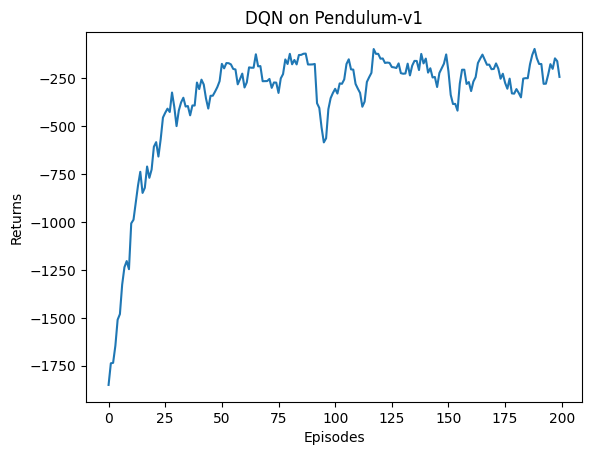

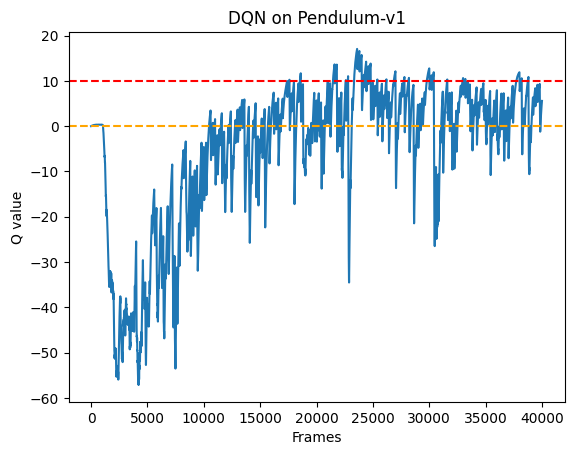

In [23]:
random.seed(0)
np.random.seed(0)
# _ = env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size) ## 实例化缓冲池也就是历史数据
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list, allimage = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

# https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'C:\Users\10696\Desktop\access\Hands-on-RL\chapter8_0.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s, episode=200, return=-172.830]


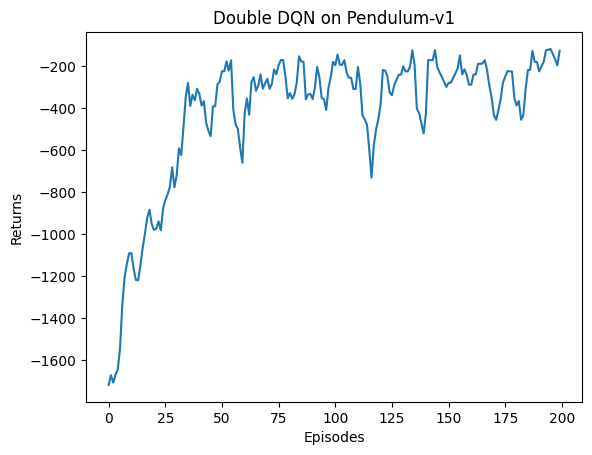

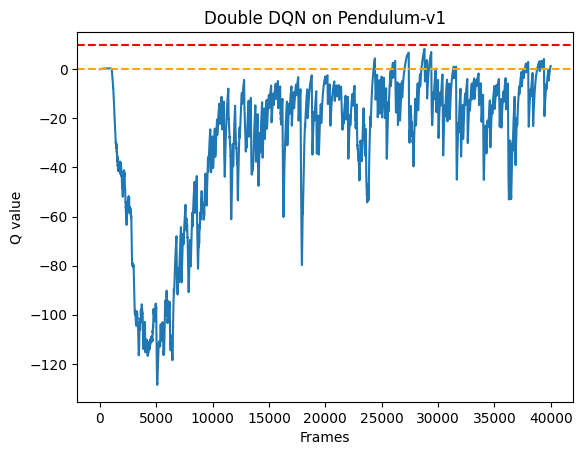

In [24]:
random.seed(0)
np.random.seed(0)
# _ = env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size) ## 实例化缓冲池也就是历史数据
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list, allimage = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

# https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'C:\Users\10696\Desktop\access\Hands-on-RL\chapter8_1.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, episode=200, return=-169.990]


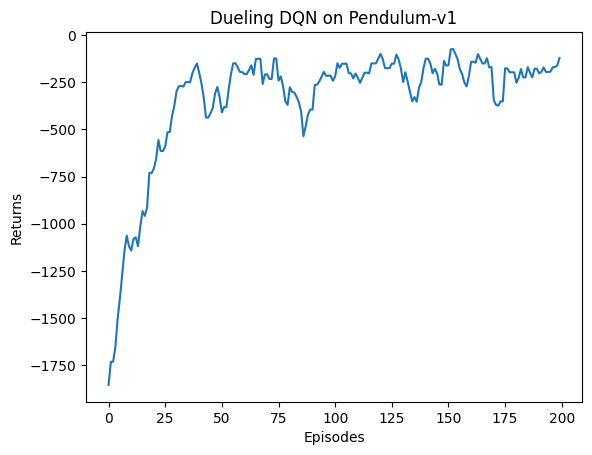

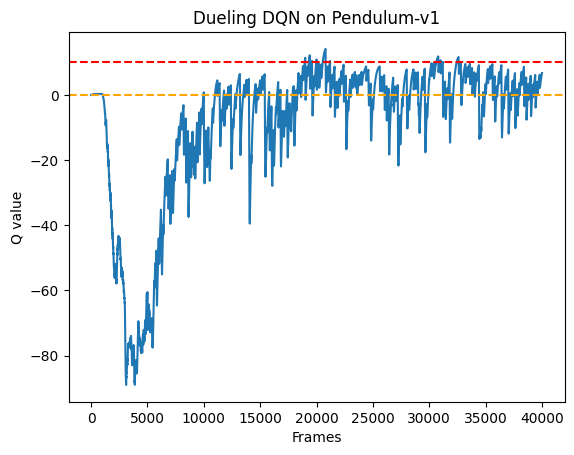

In [29]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim) ## 优势函数的
        self.fc_V = torch.nn.Linear(hidden_dim, 1) ## 状态价值函数的

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        ## 残差网络的resnet，可以减去A内的均值，也可以不减的
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim  ##  动作的dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            ## 实例化智能体的大脑
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            ## 实例化智能体的大脑
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        # if np.random.random() < self.epsilon * np.exp(-self.count/100):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim) ## 随机选择一个动作
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device) ## 状态
            action = self.q_net(state).argmax().item()  ## 智能体的大脑，根据状态拿到动作价值，q_net返回值是每个动作的动作价值，然后拿到动作的
        return action
    
    ## 拿到一个状态对应的所有动作的动作价值，并返回动作价值的最大值
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    ## 使用历史数据来训练智能体的大脑，两个大脑的，一个实时update做label，另一个延迟update做predict
    '''
    损失函数需要label和predict，但是强化学习是没有label的，所以需要人工构造label才行，DQN使用的构造方式是使用update步长不相同的两个Qnet，
    update数量较多的Qnet来做label，数量较少的Qnet来做predict。所以label就是使用的newest update的Qnet。相当是两个人，一个学的时间长些，
    一个学的时间短些，所以这个学习时间更长的人，可以当老师了，学习时间短的人，就只能当学生了。老师可以教导学生的。所以两个大脑模型Qnet，
    一个做老师，一个是学生，也就是一个label另一个则是predict。这样就构造出了相应的label。
    target_q_net使用下一个状态，然后Q-learning来predict当前(状态，动作)的动作价值，predict
    q_net使用当前状态和动作，直接算出当前(状态，动作)的动作价值，label
    '''
    def update(self, transition_dict):
        ## 初始化 状态、动作、奖励、下一个状态、是否结束的
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        ## target, 因该网络实时update，所以可以看作是真实值，也就是监督学习内的label，而目标网络延迟很多，目标网络的输出可以看作predict
        ## “真实”label，q_net输入当前的状态，返回值是当前状态下每个动作的动作价值，所以gather以后拿到的是：当前(状态和动作)对应的动作价值
        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)    ## 统一动作网络，由q_net网络来给出下个状态的动作，标准是最大值
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)    ## target_q_net网络给出动作价值，并通过动作选择动作价值
        else: # DQN的情况
            ## target_q_net网络给出动作价值，并直接挑选某个状态动作内的最大值，和q_net的动作可能不相同
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        ## Q-learning algorithm，算出的是当前(状态和动作)的动作价值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        ## q_net的truth label 和 target_q_net的predict，算损失用来反向传播
        ## 也就是两个网络算出来的（状态和动作）对应的动作价值，用MSE来算损失函数的呢
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()   ##  反向传播求出梯度
        self.optimizer.step() ##  使用累加的梯度来update参数

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size) ## 实例化缓冲池也就是历史数据
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list, allimage = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

# https://github.com/guicalare/Img2gif/blob/master/Code/Img2Gif.py
imageio.mimsave(r'C:\Users\10696\Desktop\access\Hands-on-RL\chapter8_2.gif', allimage, duration=10)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()